# A New QR Algorithm

The step we use is given by $$A(nb+1:n,nb+1:n)\leftarrow A(nb+1:n, nb+1:n)-A(nb+1:n,1:nb)\times A(1:nb,nb+1:n)$$

In [1]:
using LinearAlgebra
using Plots
using Plots.PlotMeasures


In [2]:
function NewHouseholderQR(A)
    n,_ = size(A)
    Tau = zeros(ComplexF64, n-1)
    for nb in 1:(n-1)
        phase = A[nb,nb]/abs(A[nb,nb])
        Tau[nb] = (1+abs(A[nb, nb]))
        A[nb, nb] += phase
        A[nb:n, nb] = A[nb:n, nb]/(phase*Tau[nb])
        A[nb,nb] = -phase
        A[nb+1:n,nb+1:n]= A[nb+1:n, nb+1:n]-A[nb+1:n,nb].*A[nb:nb, nb+1:n]
    end
    A, Tau
end

function GetR(A, Tau)
    diagm(0 => diag(A, 0))
end

function GetQ(A, Tau)
    n, _ = size(A)
    Q = diagm(ones(ComplexF64, n))
    for i in n-1:-1:1
        u = A[i:n, i]
        u[1] = 1
        Q[i:n, :] = Q[i:n, :] - Tau[i] * u * (u' * Q[i:n, :])
    end
    Q
end

GetQ (generic function with 1 method)

In [3]:

function GenerateRandUnitaries(n)
    [Matrix(qr(rand(ComplexF64, (2^i,2^i))).Q) for i=1:n]
end

n = 10
U = Matrix(qr(rand(ComplexF64, (2^n, 2^n))).Q)
UCopy = deepcopy(U)
OurHH = NewHouseholderQR(U)
OurR = GetR(OurHH[1], OurHH[2])
OurQ = GetQ(OurHH[1], OurHH[2])
Res = (OurQ * OurR)
UCopy≈Res

true

## Verification and Generation function
used to for ease of running multiple

In [4]:
function verify_qr(A_OG, A_Factor, Tau) # function for easy verification
    B= deepcopy(A_Factor)

    Q = GetQ(B, Tau)
    R = GetR(B, Tau)
    Result=(Q*R)
    success = A_OG ≈Result

    if success ==true
        println("passed") # lowkey unsure if this should print this, kinda annoying
    else
        println("failed")
    end
    return success
end

function GenRandUnitary(n)
    return Matrix(qr(rand(ComplexF64, 2^n, 2^n)).Q)
end

GenRandUnitary (generic function with 1 method)

# READ
### Only run the below if you have a CUDA GPU, otherwise it just wastes sm space and time

In [5]:
using CUDA # dont run unless you wanna install a shit ton of stuff, takes a while too.
using CSV
using DataFrames

#### Just run this cell below if you do not have 

In [6]:
hasCUDA = false # just run this if you have no gpu

false

In [7]:
if CUDA.functional()
    println("GPU detected: $(CUDA.name(CUDA.device()))")
    hasCUDA = true
else
    println("NO CUDA GPU, wont run.")
    hasCUDA = false
end

GPU detected: NVIDIA GeForce RTX 3070 Ti Laptop GPU


true

#### This only runs the cpu: 

In [8]:
if hasCUDA == false # THIS WILL ONLY RUN IF THERE IS NO CUDA GPU, IGNORE OTHERWISE, JUST FOR TESTING W/O GPU 
    n_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]# biggest is 2048 x 2048, if you want more sacrifice ur own runtime/life
    gen_times = Float64[]
    qr_times = Float64[]
    verify_times = Float64[]
    
    for n in n_values
        println("n = $n")
        gen_time = @elapsed U = GenRandUnitary(n)
    
        if gen_time > 1.0
            println("Generation: $(round(gen_time, digits=6)) seconds")
        end
        
        U_copy = deepcopy(U)
        
        qr_time = @elapsed A, Tau = NewHouseholderQR(U_copy)
        if qr_time > 1.0
            println("QR: $(round(qr_time, digits=6)) seconds")
        end
        
        verify_time = @elapsed verify_qr(U, A, Tau)
        if verify_time > 1.0
            println("Verification: $(round(verify_time, digits=6)) seconds")
        end
        
        push!(gen_times, gen_time)
        push!(qr_times, qr_time)
        push!(verify_times, verify_time)
    end
    
    plot(n_values, [gen_times qr_times verify_times],
         label=["Generation" "QR Decomposition" "Verification"],
         xlabel="n (matrix size = 2^n)",
         ylabel="Seconds",
         marker=:circle,
         legend=:topleft)
end

#### The real deal, speedup is not much rn but I think its cause the algorithm is the base one with no BLAS.


CPU Benchmark:
n = 1 (CPU)
passed
n = 2 (CPU)
passed
n = 3 (CPU)
passed
n = 4 (CPU)
passed
n = 5 (CPU)
passed
n = 6 (CPU)
passed
n = 7 (CPU)
passed
n = 8 (CPU)
passed
n = 9 (CPU)
passed
Verification: 1.055751 seconds
n = 10 (CPU)
QR: 2.535828 seconds
passed
Verification: 6.969442 seconds
n = 11 (CPU)
Generation: 1.348072 seconds
QR: 33.012819 seconds
passed
Verification: 80.478926 seconds

GPU Benchmark:
n = 1 (GPU)
passed
n = 2 (GPU)
passed
n = 3 (GPU)
passed
n = 4 (GPU)
passed
n = 5 (GPU)
passed
n = 6 (GPU)
passed
n = 7 (GPU)
passed
n = 8 (GPU)
QR: 1.579014 seconds
passed
n = 9 (GPU)
passed
n = 10 (GPU)
QR: 2.534226 seconds
passed
Verification: 7.59585 seconds
n = 11 (GPU)
Generation + Transfer: 1.459273 seconds
QR: 28.798207 seconds
passed
Verification: 74.803603 seconds

Results in NewHouseholderQR_benchmark_results.csv


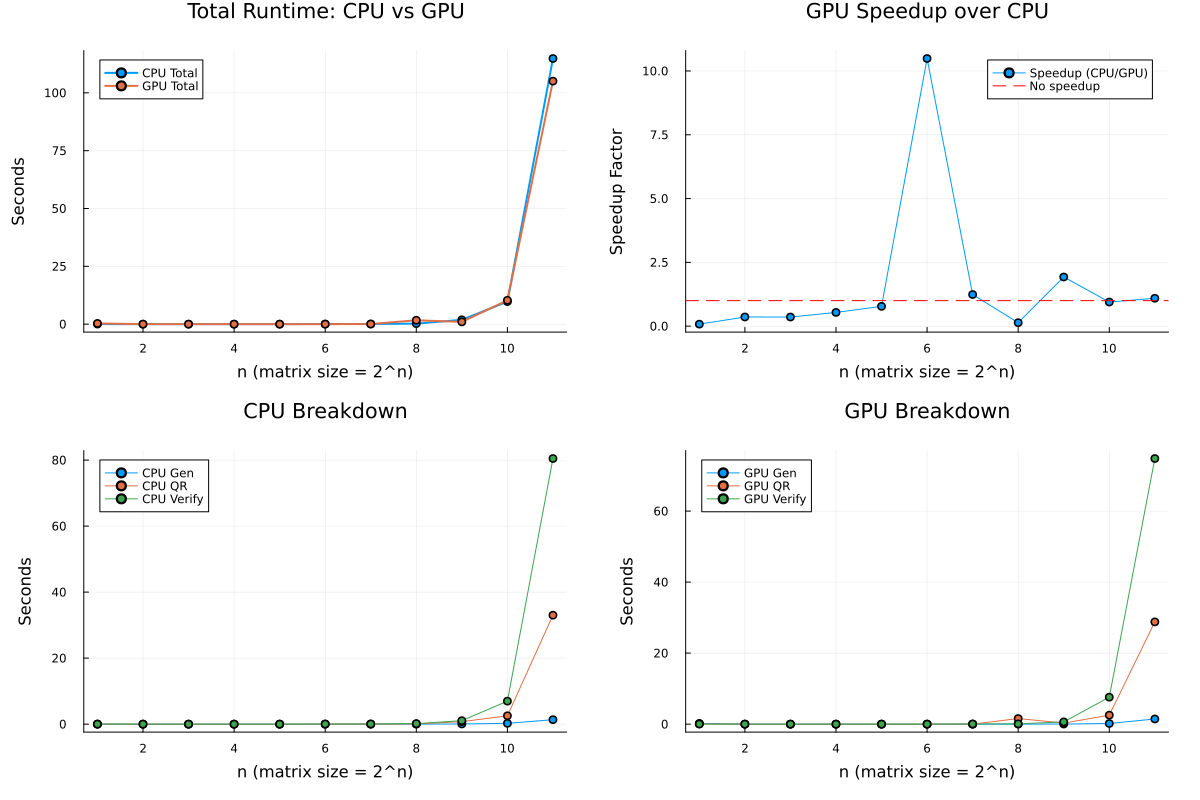

In [9]:
if hasCUDA == true
    
    n_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] # biggest is 2048 x 2048, if you want more sacrifice ur own runtime/life
    
    # on dat cpu timing
    cpu_gen_times = Float64[]
    cpu_qr_times = Float64[]
    cpu_verify_times = Float64[]
    
    # gpu timing
    gpu_gen_times = Float64[]
    gpu_qr_times = Float64[]
    gpu_verify_times = Float64[]
    
    
    println("\nCPU Benchmark:")
    for n in n_values
        println("n = $n (CPU)")
        gen_time = @elapsed U = GenRandUnitary(n)
        if gen_time > 1.0
            println("Generation: $(round(gen_time, digits=6)) seconds")
        end
        
        U_copy = deepcopy(U)
        qr_time = @elapsed A, Tau = NewHouseholderQR(U_copy)
        if qr_time > 1.0
            println("QR: $(round(qr_time, digits=6)) seconds")
        end
        
        verify_time = @elapsed verify_qr(U, A, Tau)
        if verify_time > 1.0
            println("Verification: $(round(verify_time, digits=6)) seconds")
        end
        
        push!(cpu_gen_times, gen_time)
        push!(cpu_qr_times, qr_time)
        push!(cpu_verify_times, verify_time)
    end

    
    println("\nGPU Benchmark:")
    for n in n_values
        println("n = $n (GPU)")
        
        # generaitng a random unitary matrix uses cpu op, so gen on there then transfer to gpu.
        gen_time = @elapsed begin
            U_cpu = GenRandUnitary(n)
            U = CuArray(U_cpu)
            CUDA.synchronize()
        end
        
        if gen_time > 1.0
            println("Generation + Transfer: $(round(gen_time, digits=6)) seconds")
        end
        
        U_copy = copy(U)
        
        qr_time = @elapsed begin
            A = CuArray(Array(U_copy))  # Convert back and forth to ensure proper handling
            A_cpu = Array(A)
            A_result, Tau = NewHouseholderQR(A_cpu)
            A = CuArray(A_result)
            Tau_gpu = CuArray(Tau)
            CUDA.synchronize()
        end
        
        if qr_time > 1.0
            println("QR: $(round(qr_time, digits=6)) seconds")
        end

        
        verify_time = @elapsed begin
            U_verify = Array(U)
            A_verify = Array(A)
            Tau_verify = Array(Tau_gpu)
            verify_qr(U_verify, A_verify, Tau_verify)
        end
        
        if verify_time > 1.0
            println("Verification: $(round(verify_time, digits=6)) seconds")
        end
        
        push!(gpu_gen_times, gen_time)
        push!(gpu_qr_times, qr_time)
        push!(gpu_verify_times, verify_time)
    end
    
    
    cpu_total_times = cpu_gen_times .+ cpu_qr_times .+ cpu_verify_times
    gpu_total_times = gpu_gen_times .+ gpu_qr_times .+ gpu_verify_times # get the total times for both

    
    # DATAFRAME to export to a csv, cuz why not.
    df = DataFrame(
        n = n_values,
        matrix_size = [2^n for n in n_values],
        cpu_gen = cpu_gen_times,
        cpu_qr = cpu_qr_times,
        cpu_verify = cpu_verify_times,
        cpu_total = cpu_total_times,
        gpu_gen = gpu_gen_times,
        gpu_qr = gpu_qr_times,
        gpu_verify = gpu_verify_times,
        gpu_total = gpu_total_times,
        speedup = cpu_total_times ./ gpu_total_times
    ) # This can be deleted , was doing it so i can see the exact times. i dont think its neccesarry for the reqs tho
    
    CSV.write("NewHouseholderQR_benchmark_results.csv", df) # same as above ^^
    println("\nResults in NewHouseholderQR_benchmark_results.csv")
    
    

    # plethora of plots, prolly dont need all. 
    p1 = plot(n_values, [cpu_total_times gpu_total_times],
              label=["CPU Total" "GPU Total"],
              xlabel="n (matrix size = 2^n)",
              ylabel="Seconds",
              title="Total Runtime: CPU vs GPU",
              lw=2,
              marker=:circle,
              legend=:topleft)
    
    p2 = plot(n_values, cpu_total_times ./ gpu_total_times,
              label="Speedup (CPU/GPU)",
              xlabel="n (matrix size = 2^n)",
              ylabel="Speedup Factor",
              title="GPU Speedup over CPU",
              marker=:circle,
              legend=:topright)
    hline!([1.0], label="No speedup", linestyle=:dash, color=:red)
    
    p3 = plot(n_values, [cpu_gen_times cpu_qr_times cpu_verify_times],
              label=["CPU Gen" "CPU QR" "CPU Verify"],
              xlabel="n (matrix size = 2^n)",
              ylabel="Seconds",
              title="CPU Breakdown",
              marker=:circle,
              legend=:topleft)
    
    p4 = plot(n_values, [gpu_gen_times gpu_qr_times gpu_verify_times],
              label=["GPU Gen" "GPU QR" "GPU Verify"],
              xlabel="n (matrix size = 2^n)",
              ylabel="Seconds",
              title="GPU Breakdown",
              marker=:circle,
              legend=:topleft)
    
    plot(p1, p2, p3, p4, layout=(2,2), size=(1200, 800), margin=6mm)
end

#### any weird stuff is cause its randomly gen

like sometimes the gpu is quicker, others cpu. I think its cause the algo is not optimized for BLAS yet.

##### takes me ~285 seconds to run all cells